In [1]:
# Importing NumCosmo
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())


# Importing CLMM
import clmm
from clmm import Cosmology
from clmm.support import mock_data as mock


# Importing Numpy and SciPy and time 
import numpy as np
import scipy as sp
from numpy import random
from time import perf_counter


# Importing matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams['text.latex.preamble'] = r'\usepackage{pxfonts, mathpazo}'
plt.rc('text', usetex=True)


# # Importing ks R package and functions
# import rpy2
# from rpy2 import robjects
# from rpy2.robjects.packages import importr

# ks       = importr("ks")
# vector   = robjects.r["as.vector"]
# sphere   = robjects.r["pre.sphere"]
# t        = robjects.r["t"]
# Hscv     = robjects.r["Hscv"]
# kde      = robjects.r["kde"]
# plot_kde = robjects.r["plot"]

In [2]:
np.random.seed(1)
# Define cosmological parameters
cosmo_clmm = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

cluster_m     = 1.e15 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination
sigma_g       = 5e-2  # True ellipticity standard variation
sigma_z       = 5e-2
ndata         = 1000
scale         = 1.0e-2

In [3]:
cosmo = Nc.HICosmo.new_from_name(Nc.HICosmo, "NcHICosmoLCDM")
dp    = Nc.HaloDensityProfileNFW.new(Nc.HaloDensityProfileMassDef.CRITICAL, 200)
dist  = Nc.Distance.new(6)

dist.prepare(cosmo)

smd = Nc.WLSurfaceMassDensity.new(dist)
rng = Ncm.RNG.seeded_new("mt19937", 1)

gsdp  = Nc.GalaxySDPositionSRDY1()
gsdzp = Nc.GalaxySDZProxyGauss()
gsds  = Nc.GalaxySDShapeGauss()

gsdp.set_r_lim(Ncm.Vector.new_array([1e-6, 4.5]))
gsdp.set_z_lim(Ncm.Vector.new_array([1e-6, 4.5]))
gsdzp.set_z_lim(Ncm.Vector.new_array([1e-6, 4.5]))
gsdzp.set_sigma(sigma_z)
gsds.set_sigma(sigma_g)

gwll = Nc.GalaxyWLLikelihood(s_dist=gsds, zp_dist=gsdzp, rz_dist=gsdp)

obs_matrix = Ncm.Matrix.new(ngals, 3)

for i in range(ngals):
    obs = gwll.gen(cosmo, dp, smd, cluster_z, rng)
    for j in range(3):
        obs_matrix.set(i, j, obs.get(j))
    #     print(j, obs.get(j))
    # print('')

gwll.set_obs (obs_matrix)
gwll.set_ndata (ndata)
gwll.set_cut (0.75, 3.0)

In [4]:
gwll.prepare (cosmo, dp, smd, 0.4)

kde = gwll.peek_kde ()
kde_data = kde.peek_sample_array ()

# kde_data_long = []
# kde_data_array = []

# vector = robjects.r['as.vector']

# for i in range (len(kde_data)):
#     for j in range (3):
#         kde_data_long.append (kde_data[i].dup_array()[j])
#     kde_data_array.append (kde_data[i].dup_array())

# kde_data_array = np.array(kde_data_array)

# kde_data_vec = vector (kde_data_long, mode="numeric")
# kde_data_r   = robjects.r['matrix'](kde_data_vec, ncol=3, byrow=True)

In [5]:
# h = Hscv(x=kde_data_r, pilot="unconstr")


In [6]:
# kernel = Ncm.StatsDistKernelGauss.new(3)
# kde_hscv = Ncm.StatsDistKDE.new(kernel, Ncm.StatsDistCV.NONE)

# for i in range(len(kde_data)):
#     kde_hscv.add_obs(kde_data[i])

# kde_hscv.set_cov_type(Ncm.StatsDistKDECovType.FIXED)
# kde_hscv.set_cov_fixed(Ncm.Matrix.new_array([h[i] for i in range(len(h))], 3))
# kde_hscv.prepare()

# kde_hscv.set_over_smooth(kde_hscv.get_over_smooth() / kde_hscv.get_href())
# kde_hscv.prepare()
# # kde.set_cov_type(Ncm.StatsDistKDECovType.FIXED)
# # kde.set_cov_fixed(Ncm.Matrix.new_array([h[i] for i in range(len(h))], 3))

# kernel = Ncm.StatsDistKernelGauss.new(3)
# kde_control = Ncm.StatsDistKDE.new(kernel, Ncm.StatsDistCV.NONE)

# for i in range(len(kde_data)):
#     kde_control.add_obs(kde_data[i])

# kde_control.prepare()



# kde.set_cv_type(Ncm.StatsDistCV.LOO)
# kde.set_print_fit (True)
# kde.prepare()

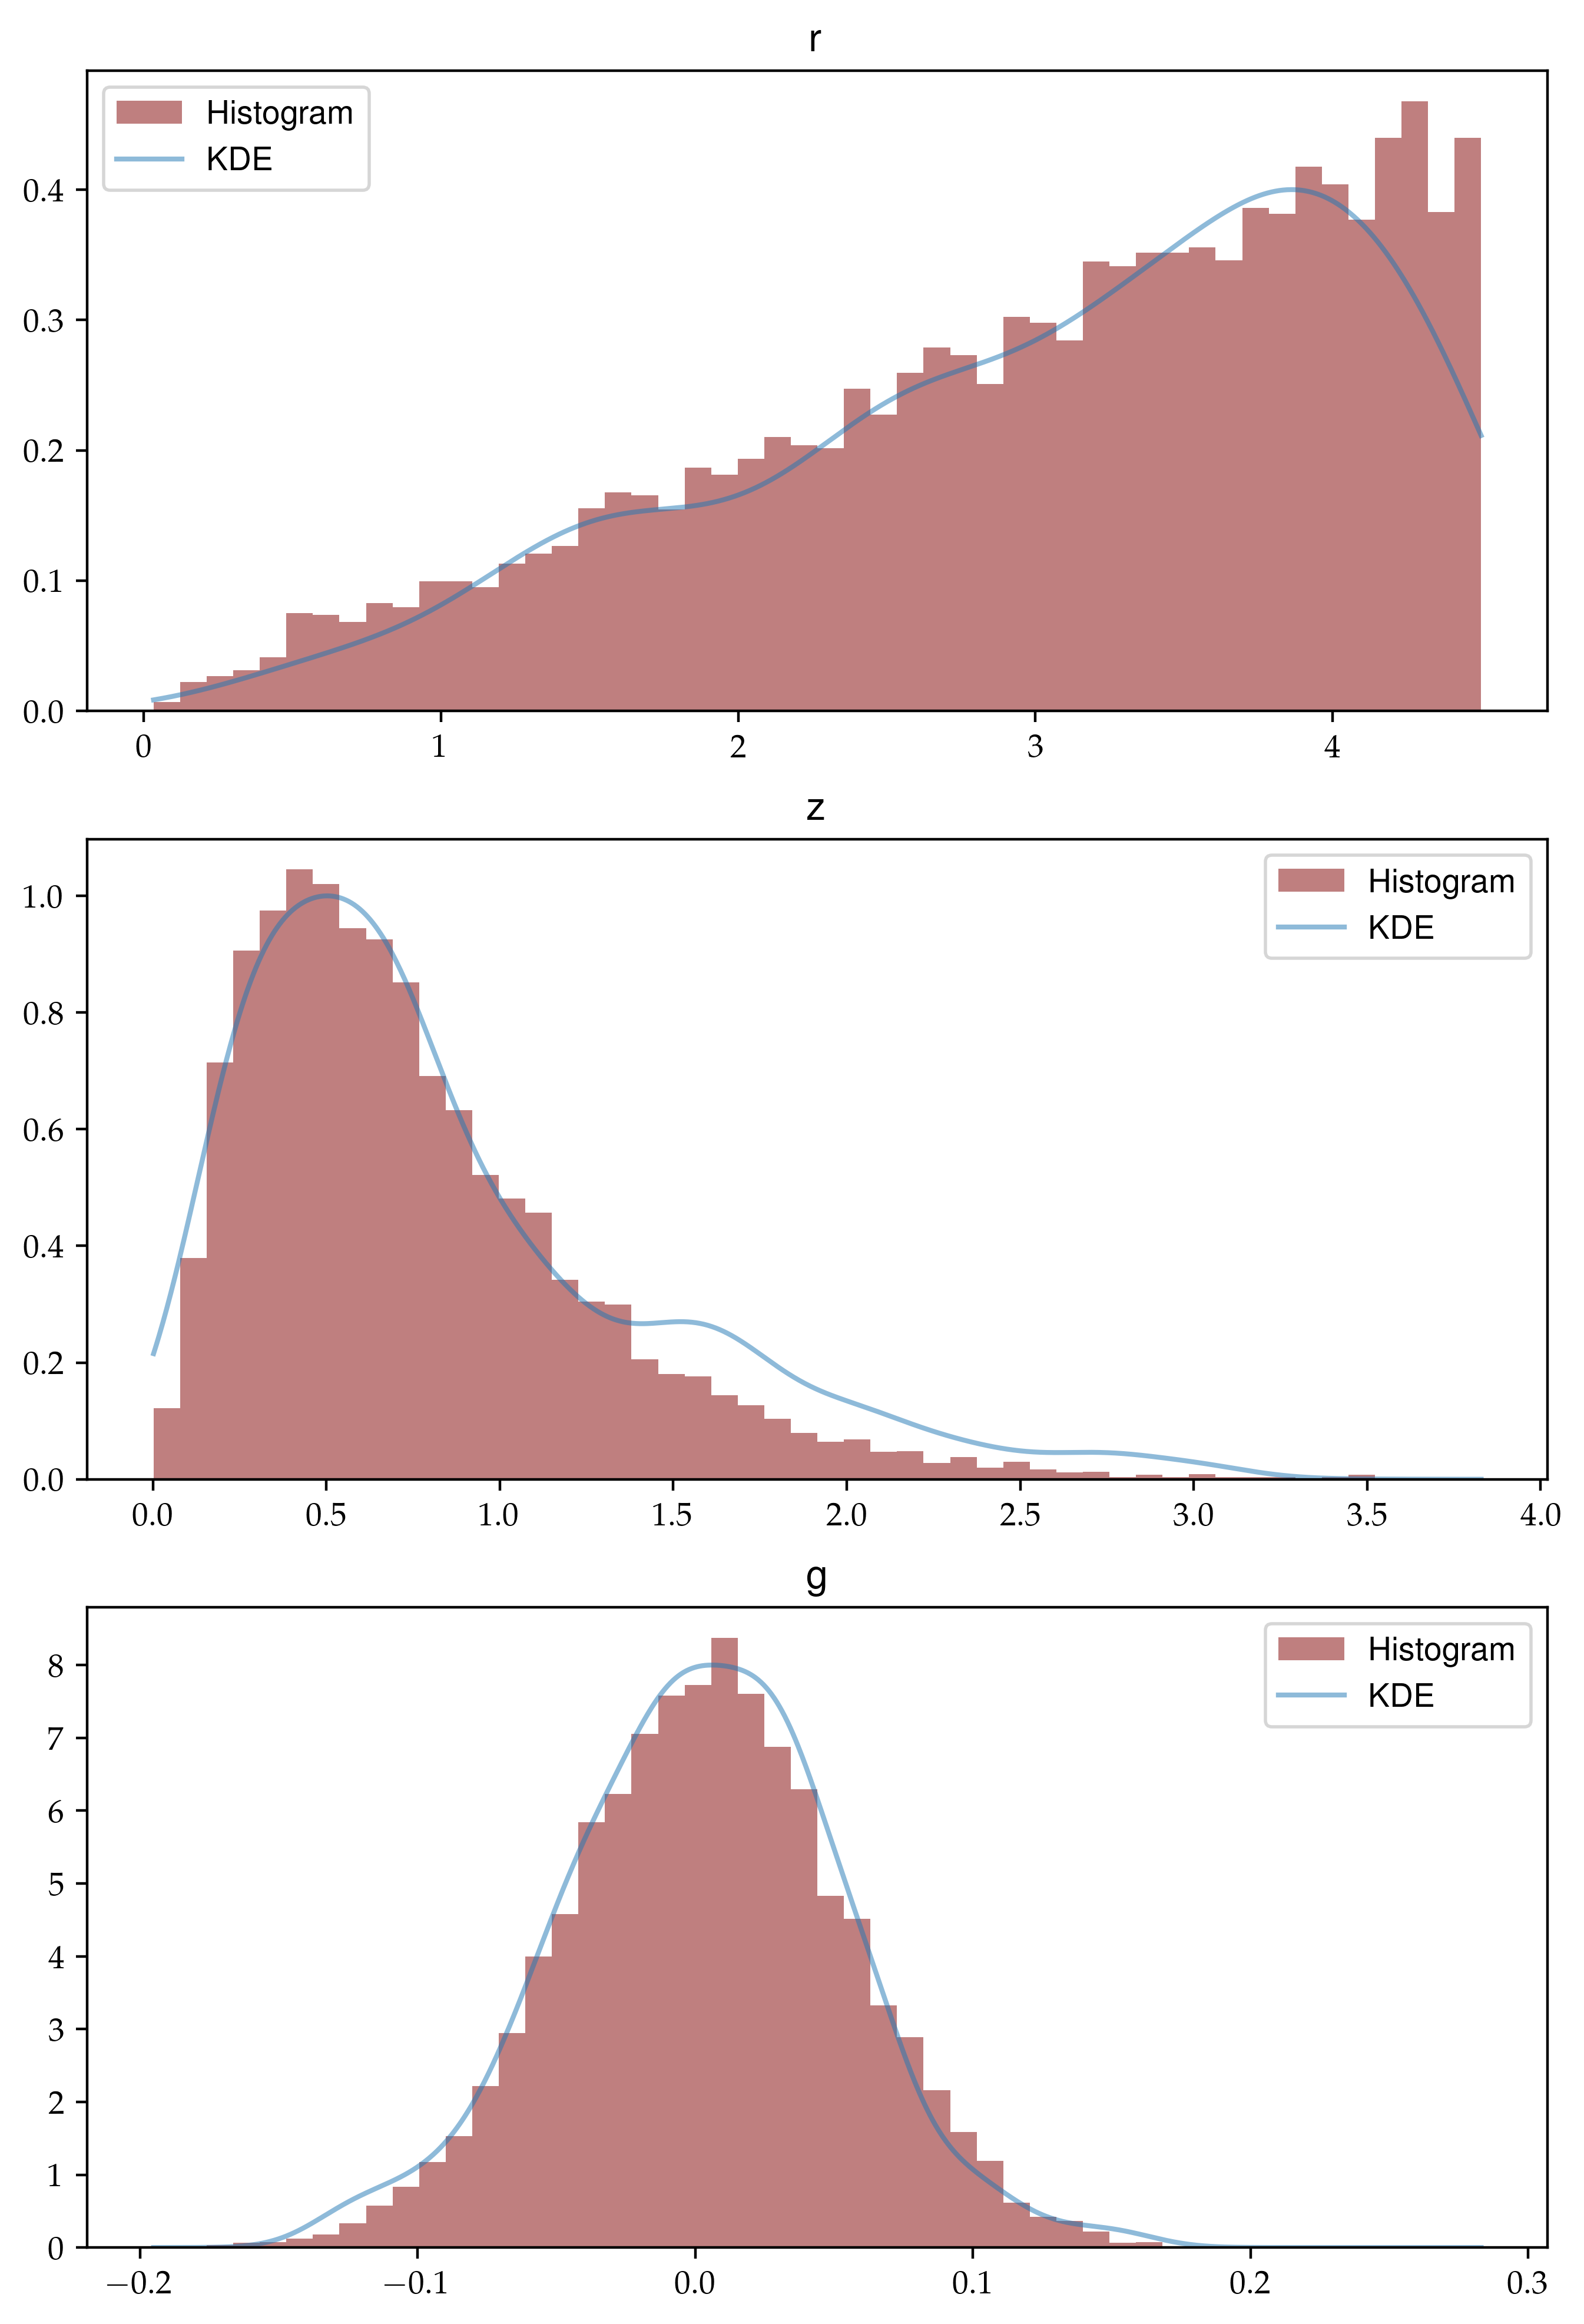

In [7]:
kde_data = [[obs_matrix.get(i, j) for j in range(3)] for i in range(obs_matrix.nrows())]
kde_data_array = np.array(kde_data)


fig, ax = plt.subplots (3, 1, figsize=(8, 12), dpi=400, facecolor="white")

r = np.linspace(min(kde_data_array[:,0]), max(kde_data_array[:,0]), 1000)
z = np.linspace(min(kde_data_array[:,1]), max(kde_data_array[:,1]), 1000)
g = np.linspace(min(kde_data_array[:,2]), max(kde_data_array[:,2]), 1000)


# Plotting histograms
ax[0].hist(kde_data_array[:,0], bins=50, density=True, label="Histogram", alpha=0.5, color="maroon")
ax[1].hist(kde_data_array[:,1], bins=50, density=True, label="Histogram", alpha=0.5, color="maroon")
ax[2].hist(kde_data_array[:,2], bins=50, density=True, label="Histogram", alpha=0.5, color="maroon")

# Plotting KDEs
r_kde = [kde.eval(Ncm.Vector.new_array([r[i], 0.6, 0.01])) for i in range(len(r))]
z_kde = [kde.eval(Ncm.Vector.new_array([3, z[i], 0.01])) for i in range(len(z))]
g_kde = [kde.eval(Ncm.Vector.new_array([3, 0.6, g[i]])) for i in range(len(g))]

r_kde = [r_i/max(r_kde)*0.4 for r_i in r_kde]
z_kde = [z_i/max(z_kde)*1.0 for z_i in z_kde]
g_kde = [g_i/max(g_kde)*8.0 for g_i in g_kde]

# r_kde_c = [kde_control.eval(Ncm.Vector.new_array([r[i], 0.6, 0.01])) for i in range(len(r))]
# z_kde_c = [kde_control.eval(Ncm.Vector.new_array([3, z[i], 0.01])) for i in range(len(z))]
# g_kde_c = [kde_control.eval(Ncm.Vector.new_array([3, 0.6, g[i]])) for i in range(len(g))]

# r_kde_hscv = [kde_hscv.eval(Ncm.Vector.new_array([r[i], 0.6, 0])) for i in range(len(r))]
# z_kde_hscv = [kde_hscv.eval(Ncm.Vector.new_array([2.8, z[i], 0])) for i in range(len(z))]
# g_kde_hscv = [kde_hscv.eval(Ncm.Vector.new_array([2.8, 0.6, g[i]])) for i in range(len(g))]

# ax[0].plot(r, r_kde_hscv, label="HSCV", color="tab:red", alpha=0.5)
# ax[0].plot(r, r_kde_c, label="KDE CONTROL", color="tab:green", alpha=0.5)
ax[0].plot(r, r_kde, label="KDE", color="tab:blue", alpha=0.5)

# ax[1].plot(z, z_kde_hscv, label="HSCV", color="tab:red", alpha=0.5)
# ax[1].plot(z, z_kde_c, label="KDE CONTROL", color="tab:green", alpha=0.5)
ax[1].plot(z, z_kde, label="KDE", color="tab:blue", alpha=0.5)

# ax[2].plot(g, g_kde_hscv, label="HSCV", color="tab:red", alpha=0.5)
# ax[2].plot(g, g_kde_c, label="KDE CONTROL", color="tab:green", alpha=0.5)
ax[2].plot(g, g_kde, label="KDE", color="tab:blue", alpha=0.5)

ax[0].set_title("r")
ax[1].set_title("z")
ax[2].set_title("g")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [8]:
# cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
# moo = clmm.Modeling (massdef='mean', delta_mdef=200, halo_profile_model='nfw')
# moo.set_cosmo(cosmo)
# mset = moo.get_mset ()

# data = mock.generate_galaxy_catalog (cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=sigma_g, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec, photoz_sigma_unscaled=sigma_z)
# gc   = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)
# gc.compute_tangential_and_cross_components(geometry="flat")

# radius = clmm.convert_units (gc.galcat['theta'], "radians", "Mpc", redshift = cluster_z, cosmo = cosmo)
# r_mean = np.mean (radius)
# g_mean = np.mean (gc.galcat['et'])
# z_mean = np.mean (gc.galcat['z'])

# r_x = np.linspace (r_lim[0], r_lim[1], 1000)
# z_x = np.linspace (z_lim[0], z_lim[1], 1000)
# g_x = np.linspace (min (gc.galcat['et']), max (gc.galcat['et']), 1000)
r_x = r
z_x = z
g_x = g

r_mean = np.mean (3.0)
z_mean = np.mean (0.5)
g_mean = np.mean (0.01)

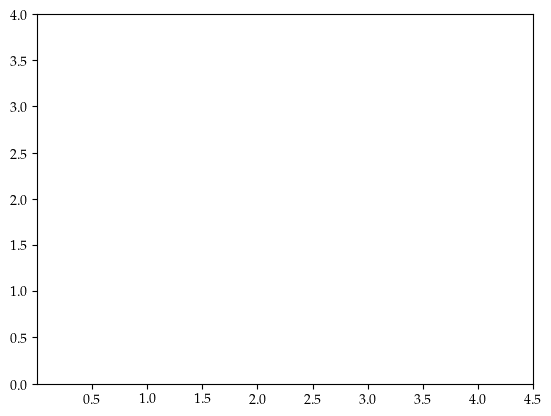

In [9]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
z_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
g_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    z_text.set_text ('')
    g_text.set_text ('')
    return line,

def animate(z):
    p_r = []
    for i in range (len(r_x)):
        x = Ncm.Vector.new_array ([r_x[i], z, g_mean])
        p_r.append (kde.eval (x))
    line.set_data(r_x, p_r)
    z_text.set_text (f'z = {z}')
    g_text.set_text (f'g = {g_mean}')
    # axis.relim ();
    axis.set_xlim (1e-6, 4.5)
    axis.set_ylim (0, 4)
    return line, z_text, g_text

anim = FuncAnimation(fig, animate, init_func = init, frames = z_x, interval = 20, blit = False)
anim.save(f'r_z_loo_{ndata}.mp4', writer = 'ffmpeg', fps = 24)

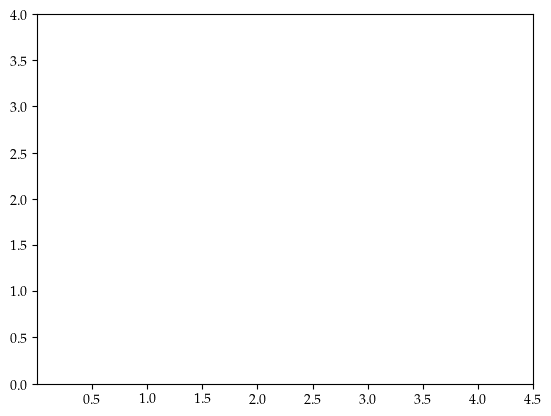

In [10]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
z_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
g_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    z_text.set_text ('')
    g_text.set_text ('')
    return line,

def animate(g):
    p_r = []
    for i in range (len(r_x)):
        x = Ncm.Vector.new_array ([r_x[i], 0.6, g])
        p_r.append (kde.eval (x))
    line.set_data(r_x, p_r)
    z_text.set_text (f'z = {0.6}')
    g_text.set_text (f'g = {g}')
    axis.set_xlim (1e-6, 4.5)
    axis.set_ylim (0, 4)
    return line, z_text, g_text

anim = FuncAnimation(fig, animate, init_func = init, frames = g_x, interval = 20, blit = False)
anim.save(f'r_g_loo_{ndata}.mp4', writer = 'ffmpeg', fps = 24)

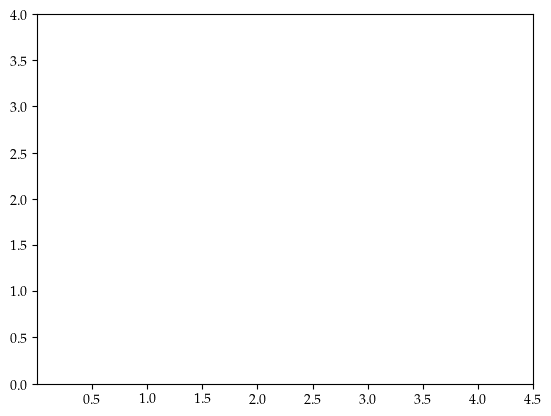

In [11]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
r_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
g_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    r_text.set_text ('')
    g_text.set_text ('')
    return line,

def animate(r):
    p_z = []
    for i in range (len(z_x)):
        x = Ncm.Vector.new_array ([r, z_x[i], g_mean])
        p_z.append (kde.eval (x))
    line.set_data(z_x, p_z)
    r_text.set_text (f'r = {r}')
    g_text.set_text (f'g = {g_mean}')
    axis.set_xlim (1e-6, 4.5)
    axis.set_ylim (0, 4)
    return line, r_text, g_text

anim = FuncAnimation(fig, animate, init_func = init, frames = r_x, interval = 20, blit = False)
anim.save(f'z_r_loo_{ndata}.mp4', writer = 'ffmpeg', fps = 24)

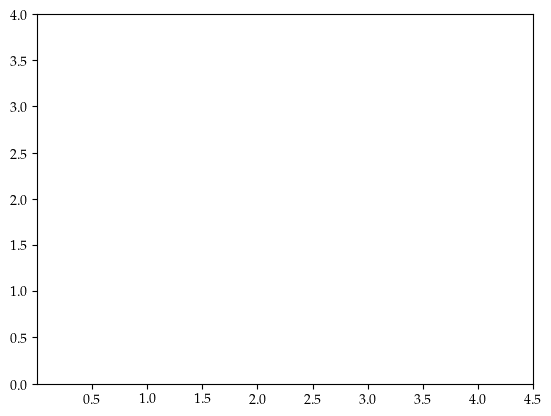

In [12]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
r_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
g_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    r_text.set_text ('')
    g_text.set_text ('')
    return line,

def animate(g):
    p_z = []
    for i in range (len(z_x)):
        x = Ncm.Vector.new_array ([r_mean, z_x[i], g])
        p_z.append (kde.eval (x))
    line.set_data(z_x, p_z)
    r_text.set_text (f'r = {r_mean}')
    g_text.set_text (f'g = {g}')
    axis.set_xlim (1e-6, 4.5)
    axis.set_ylim (0, 4)
    return line, r_text, g_text

anim = FuncAnimation(fig, animate, init_func = init, frames = g_x, interval = 20, blit = False)
anim.save(f'z_g_loo_{ndata}.mp4', writer = 'ffmpeg', fps = 24)

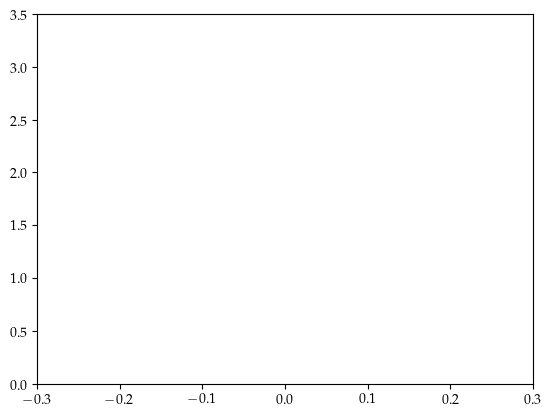

In [13]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
r_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
z_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    r_text.set_text ('')
    z_text.set_text ('')
    return line,

def animate(r):
    p_g = []
    for i in range (len(g_x)):
        x = Ncm.Vector.new_array ([r, z_mean, g_x[i]])
        p_g.append (kde.eval (x))
    line.set_data(g_x, p_g)
    r_text.set_text (f'r = {r}')
    z_text.set_text (f'z = {z_mean}')
    axis.set_xlim (-0.3, 0.3)
    axis.set_ylim (0, 3.5)
    return line, r_text, z_text

anim = FuncAnimation(fig, animate, init_func = init, frames = r_x, interval = 20, blit = False)
anim.save(f'g_r_loo_{ndata}.mp4', writer = 'ffmpeg', fps = 24)

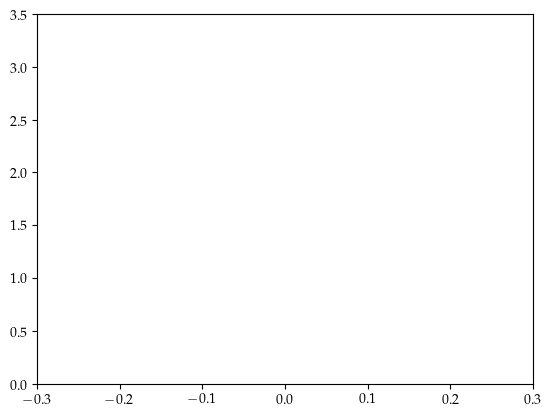

In [14]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
r_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
z_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    r_text.set_text ('')
    z_text.set_text ('')
    return line,

def animate(z):
    p_g = []
    for i in range (len(g_x)):
        x = Ncm.Vector.new_array ([r_mean, z, g_x[i]])
        p_g.append (kde.eval (x))
    line.set_data(g_x, p_g)
    r_text.set_text (f'r = {r_mean}')
    z_text.set_text (f'z = {z}')
    axis.set_xlim (-0.3, 0.3)
    axis.set_ylim (0, 3.5)
    return line, r_text, z_text

anim = FuncAnimation(fig, animate, init_func = init, frames = z_x, interval = 20, blit = False)
anim.save(f'g_z_loo_{ndata}.mp4', writer = 'ffmpeg', fps = 24)